In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [4]:
net = load_model('/mnt/fs5/dbear/pretrained_weights/centroid-tdw-selfsup-bs4-scaledmse-fullplay-tr0-8.pth',
                 train=True, cuda=True, freeze_bn=False, gpus=[0])
# net = load_model('../checkpoints/raft-tdw-bn-fullplay.pth',
#                  train=False, cuda=True, freeze_bn=False, gpus=[0])


<All keys matched successfully>


In [5]:
# act_net = load_model('../checkpoints/thingness-tdw-selfsup-bs2-small-20frames.pth', 
#                      small=True, train=True, cuda=True, freeze_bn=True, gpus=[0])
act_net = load_model('/mnt/fs5/dbear/pretrained_weights/thingness-tdw-selfsup-bs4-small-20frames-fullplay-tr0-8.pth', 
                     small=True, train=True, cuda=True, freeze_bn=True, gpus=[0])

<All keys matched successfully>


In [6]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(4)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

500
True


In [6]:
import time 

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False):
    dataset.is_test = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  

# def viz_h0_prediction(thingness_model, centroid_model, dataset, ex=0, iters=[1,6,12], thresh=None):
#     pass



In [7]:
import bootraft
import dorsalventral.models.segmentation.competition as competition
kpnet = bootraft.KpPrior(
    net, act_net, normalize_coordinates=True, randomize_background=True, resolution=6, 
    thingness_thresh=0.1, norm_p=2.0
).cuda()
comp = competition.Competition(num_masks=32, num_competition_rounds=3, compete_thresh=0.2).cuda()

In [8]:
val_dataset = raft_datasets.TdwAffinityDataset(training=False, mean=None, std=None,
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True,
                                          is_test=True)
print(len(val_dataset))

500


In [82]:
import dorsalventral.trainval.segmentation_metrics as metrics
from tqdm import tqdm

def get_h0_segments(image, prior_model, mask_model, competition_model, iters=24, thresh=None, downsample=1):
    _thresh = prior_model.thingness_thresh
    if thresh is not None:
        prior_model.thingness_thresh = thresh
    h = prior_model(image[None].cuda(), image[None].cuda(), test_mode=True)
    _, thing = mask_model(image.cuda()[None], image.cuda()[None], iters=iters, test_mode=True)
    m = (torch.sigmoid(thing) > prior_model.thingness_thresh)[:,0,...,None].float()
    h = h.permute(0,2,3,1)
    h = torch.cat([1-m, h*m], -1)
    
    if downsample is not None:
        H,W = h.shape[-3:-1]
        resize = transforms.Resize([H//downsample, W//downsample])
        h = resize(h.permute(0,3,1,2)).permute(0,2,3,1)
        thing = resize(thing)
    
    masks = competition_model(h)[0]
    
    ## postprocess masks for visualization
    labels = torch.unique(masks.argmax(-1))
    masks = (labels.view(1,1,1,-1) == masks.argmax(-1)[...,None]).float()    
    areas = masks.sum(dim=(1,2))[0]
    k_inds = torch.argsort(areas, descending=True)
    masks = masks[0].permute(2,0,1)[k_inds,:,:].permute(1,2,0)[None]
    
    prior_model.thingness_thresh = _thresh
    
    return (h, masks, thing)

def viz_h0_segments(dataset, ex, prior_model, mask_model, competition_model, iters=12, 
                    thresh=None, downsample=None, do_plot=True):
    img, gt, _ = dataset[ex]
    h0, masks, things = get_h0_segments(img, prior_model, mask_model, competition_model, iters=iters, 
                                thresh=thresh, downsample=downsample)
    
    if do_plot:
        
        fig, axes = plt.subplots(1,5,figsize=(16,4))
        titles = ['image', 'things', 'h0 (plateaus)', 'pred masks', 'gt masks']
        cmaps = [None, 'inferno', 'YlGnBu', 'twilight', 'viridis']
        plots = {
            0: tensor_to_arr(img / 255.),
            1: tensor_to_arr(h0.argmax(-1) != 0),
            2: tensor_to_arr(h0.argmax(-1)),
            3: tensor_to_arr(masks.argmax(-1)),
            4: tensor_to_arr(gt[None])
        }
        for i, ax in enumerate(axes):
            p = plots[i]
            if i == 3:
                ax.imshow(p, cmap=cmaps[i], vmax=masks.shape[-1]+1)
            else:
                ax.imshow(p, cmap=cmaps[i])
            ax.set_title(titles[i], fontsize=18)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()    
        
    return (masks.argmax(-1), gt[None])

def get_iou(pred, gt):
    M = metrics.SegmentationMetrics(
        gt_objects=gt.to(torch.int32),
        pred_objects=pred.to(torch.int32).cpu(),
        size=list(gt.shape[-2:])
    )
    M.compute_matched_IoUs(exclude_gt_ids=[0])
    return (M.mean_ious, M.best_ious)

def get_ious(dataset, examples, *args, **kwargs):
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    best_ious, mean_ious = [], []
    for ex in tqdm(examples):
        pred, gt = viz_h0_segments(dataset, ex, do_plot=False, *args, **kwargs)
        M = metrics.SegmentationMetrics(
            gt_objects=gt.to(torch.int32),
            pred_objects=pred.to(torch.int32).cpu()
        )
        M.compute_matched_IoUs(exclude_gt_ids=[0])
        best_ious.append(M.best_ious)
#         print(ex, best_ious[ex])
        mean_ious.append(M.mean_ious)

    mean_ious = np.array(mean_ious)
    grand_mean = np.nanmean(mean_ious)
    return (grand_mean, mean_ious, best_ious)

def compare_learned_to_random_init(dataset, ex, 
                                   affinities,
                                   prior_model,
                                   mask_model,
                                   competition_model,
                                   propagation_model,
                                   downsample=8,
                                   thresh=0.05,
                                   iters=24,
                                   resolution=16,
                                   num_masks_h0=32,
                                   num_masks=128,
                                   thing_init=True,
                                   random_background=False
                                  ):
    
    ## get the h0_masks and gt
    img, gt, _ = dataset[ex]
    gt = gt[None]
    prior_model.resolution = resolution
    competition_model.num_masks = num_masks_h0
    h0, h0_masks, things = get_h0_segments(img, prior_model, mask_model, competition_model,
                                           thresh=thresh, iters=iters, downsample=downsample)
    competition_model.num_masks = num_masks
    
    if thresh is not None:
        things_mask = (torch.sigmoid(things) > thresh).float()
    else:
        things_mask = torch.sigmoid(things)
    
    Q = resolution ** 2
    
    h0_rand = torch.randn([1,1,h0.shape[1], h0.shape[2], Q]).float().softmax(-1).cuda()
    
    h_list, _ = KP(h0_rand, 
                ad.softmax_max_norm(affinities[None]), 
                (things_mask[:,None] if thing_init else None))
    preds_random_init = Comp(h_list[-1][:,0])[0]
    
    if random_background:
        bg, fg = h0.spilt([1,Q], dim=-1)
        h0 = (1 - bg) * fg + bg * h0_rand
    
    h_list, _ = KP(h0[:,None],
                ad.softmax_max_norm(affinities[None]),
                (things_mask[:,None] if thing_init else None))
    preds_learned_init = Comp(h_list[-1][:,0])[0]
    

    results = {
        'learned_init': get_iou(h0_masks.argmax(-1), gt)[0],
        'prop_random_init': get_iou(preds_random_init.argmax(-1), gt)[0],
        'prop_learned_init': get_iou(preds_learned_init.argmax(-1), gt)[0],
        'prop_random_init_masked': get_iou(torch.cat(
            [1-things_mask[:,0,...,None], preds_random_init], -1).argmax(-1), gt)[0],
        'prop_learned_init_masked': get_iou(torch.cat(
            [1-things_mask[:,0,...,None], preds_learned_init], -1).argmax(-1), gt)[0],        
    }
    
    return results

def val_compare(dataset, examples, affinities_files, *args, **kwargs):
    if examples is None:
        examples = range(len(dataset))
        assert len(examples) == len(affinities_files), (len(affinities_files))
    elif isinstance(examples, int):
        examples = [examples]
        
    results = []
    for ex in tqdm(examples):
        aff_file = affinities_files[ex]
        affinities = torch.load(aff_file)['affinities'].cuda()
        res = compare_learned_to_random_init(dataset, ex, affinities, *args, **kwargs)
        results.append(res)
        print(ex, res)
        
    agg_results = {k:np.zeros((len(results))) for k in results[0].keys()}
    for i,res in enumerate(results):
        for k in res.keys():
            agg_results[k][i] = res[k]
            
    return agg_results

                
# h0, preds = get_h0_segments(val_dataset[3][0], kpnet, act_net, comp)
# print(h0.shape, preds.shape)    
ex = 5
# pred, gt = viz_h0_segments(val_dataset, ex, kpnet, act_net, comp, thresh=0.05, downsample=8, iters=24)
# print(gt.shape)
# get_ious(val_dataset, range(3), kpnet, act_net, comp)



In [36]:
## load some affinities
import glob
aff_path = '/mnt/fs6/honglinc/save_data/save_tdw_affinities'
saved_affinities = sorted(glob.glob(aff_path + '/*'))

'/mnt/fs6/honglinc/save_data/save_tdw_affinities/model_split_0-0029.gt'

In [13]:
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs



In [37]:
ex = 5
# data = torch.load(os.path.join(aff_path, saved_affinities[ex]))
data = torch.load(saved_affinities[ex])
affinities = data['affinities'].cuda()

In [38]:
affinities.shape

torch.Size([1, 4096, 4096])

In [45]:
import dorsalventral.models.trainable_propagation as propagation
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.attention_decoder as ad

KP = propagation.MultiStepPropagation(
    num_iters=40, 
    excite=True, 
    inhibit=True, 
    project=True, 
    meta=False,
    meta_every=4,
    norm_p=2.0,
    adj_thresh=0.5,
    valid_thresh=None,
    normalization_mode='adjacent',
    stop_gradient=True
).cuda()

Comp = competition.Competition(num_masks=32, num_competition_rounds=3, compete_thresh=0.2).cuda()


In [79]:
# res = compare_learned_to_random_init(
#     val_dataset, ex, affinities, kpnet, act_net, Comp, KP
# )

results = val_compare(
    val_dataset, None, saved_affinities, kpnet, act_net, Comp, KP,
    thing_init=True, thresh=0.05, resolution=16
)

  0%|                                                                                                                                                                                               | 0/10 [00:00<?, ?it/s]

activated sum at it=0 tensor(811., device='cuda:0')
activated sum at it=0 tensor(811., device='cuda:0')


 10%|██████████████████▎                                                                                                                                                                    | 1/10 [00:05<00:49,  5.53s/it]

0 {'learned_init': array([0.58416632]), 'prop_random_init': array([0.4159646]), 'prop_learned_init': array([0.59999897]), 'prop_random_init_masked': array([0.57703891]), 'prop_learned_init_masked': array([0.61658132])}
activated sum at it=0 tensor(1201., device='cuda:0')
activated sum at it=0 tensor(1201., device='cuda:0')


 20%|████████████████████████████████████▌                                                                                                                                                  | 2/10 [00:11<00:44,  5.54s/it]

1 {'learned_init': array([0.81821618]), 'prop_random_init': array([0.61907135]), 'prop_learned_init': array([0.71115871]), 'prop_random_init_masked': array([0.73320824]), 'prop_learned_init_masked': array([0.80628645])}
activated sum at it=0 tensor(764., device='cuda:0')
activated sum at it=0 tensor(764., device='cuda:0')


 30%|██████████████████████████████████████████████████████▉                                                                                                                                | 3/10 [00:16<00:39,  5.60s/it]

2 {'learned_init': array([0.70171125]), 'prop_random_init': array([0.41601653]), 'prop_learned_init': array([0.61277224]), 'prop_random_init_masked': array([0.64749765]), 'prop_learned_init_masked': array([0.68720713])}
activated sum at it=0 tensor(679., device='cuda:0')
activated sum at it=0 tensor(679., device='cuda:0')


 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 4/10 [00:22<00:35,  5.84s/it]

3 {'learned_init': array([0.60987081]), 'prop_random_init': array([0.38209643]), 'prop_learned_init': array([0.61087838]), 'prop_random_init_masked': array([0.58236615]), 'prop_learned_init_masked': array([0.60960048])}
activated sum at it=0 tensor(1545., device='cuda:0')
activated sum at it=0 tensor(1545., device='cuda:0')


 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 5/10 [00:28<00:29,  5.91s/it]

4 {'learned_init': array([0.64150961]), 'prop_random_init': array([0.50970135]), 'prop_learned_init': array([0.62099126]), 'prop_random_init_masked': array([0.64190575]), 'prop_learned_init_masked': array([0.66774317])}
activated sum at it=0 tensor(893., device='cuda:0')
activated sum at it=0 tensor(893., device='cuda:0')


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 6/10 [00:34<00:23,  5.89s/it]

5 {'learned_init': array([0.74762826]), 'prop_random_init': array([0.55065895]), 'prop_learned_init': array([0.71442106]), 'prop_random_init_masked': array([0.70129226]), 'prop_learned_init_masked': array([0.74581004])}
activated sum at it=0 tensor(790., device='cuda:0')
activated sum at it=0 tensor(790., device='cuda:0')


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 7/10 [00:41<00:17,  5.98s/it]

6 {'learned_init': array([0.42446447]), 'prop_random_init': array([0.3296898]), 'prop_learned_init': array([0.50001256]), 'prop_random_init_masked': array([0.44245668]), 'prop_learned_init_masked': array([0.52026204])}
activated sum at it=0 tensor(622., device='cuda:0')
activated sum at it=0 tensor(622., device='cuda:0')


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8/10 [00:47<00:12,  6.03s/it]

7 {'learned_init': array([0.66987061]), 'prop_random_init': array([0.33030083]), 'prop_learned_init': array([0.58621342]), 'prop_random_init_masked': array([0.5928213]), 'prop_learned_init_masked': array([0.66612053])}
activated sum at it=0 tensor(506., device='cuda:0')
activated sum at it=0 tensor(506., device='cuda:0')


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 9/10 [00:52<00:05,  5.95s/it]

8 {'learned_init': array([0.57176871]), 'prop_random_init': array([0.31015171]), 'prop_learned_init': array([0.49790202]), 'prop_random_init_masked': array([0.52789109]), 'prop_learned_init_masked': array([0.56613582])}
activated sum at it=0 tensor(959., device='cuda:0')
activated sum at it=0 tensor(959., device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.92s/it]

9 {'learned_init': array([0.6258429]), 'prop_random_init': array([0.61973816]), 'prop_learned_init': array([0.7620406]), 'prop_random_init_masked': array([0.71829945]), 'prop_learned_init_masked': array([0.71687658])}


In [81]:
{k:v.mean() for k,v in results.items()}

{'learned_init': 0.6395049121269645,
 'prop_random_init': 0.44833896933899575,
 'prop_learned_init': 0.6216389209167877,
 'prop_random_init_masked': 0.6164777485886589,
 'prop_learned_init_masked': 0.6602623567159753}

In [68]:
kpnet.resolution = 16
h0, preds, things = get_h0_segments(val_dataset[ex][0], kpnet, act_net, comp, downsample=8, iters=24, thresh=0.05)
print(h0.shape, preds.shape, things.shape)

torch.Size([1, 64, 64, 257]) torch.Size([1, 64, 64, 5]) torch.Size([1, 1, 64, 64])


In [69]:
thing_init = True
rand_background = True

thing_thresh = 0.05
if thing_thresh is not None:
    things_mask = (torch.sigmoid(things) > thing_thresh).float()
else:
    things_mask = torch.sigmoid(things)
    
Q = (kpnet.resolution ** 2) 
KP.project = True
KP.meta = False
KP.meta_every = 10
KP.norm_p = 2
h0_rand = torch.randn([1,1,h0.shape[1],h0.shape[2],Q]).float().softmax(-1).cuda()

final_hs = []
comp_masks = []
for i, _h0 in enumerate([h0_rand, h0[:,None]]):
    
    if rand_background and (i == 1):
        bg, fg = _h0.split([1,Q], dim=-1)
        _h0 = (1 - bg) * fg + bg * h0_rand
        
    h_list, _ = KP(_h0, 
                   ad.softmax_max_norm(affinities[None]),
                   activated=(things_mask[:,None] if thing_init else None)
                  )
    masks = Comp(h_list[-1][:,0])[0]
    print(h_list[-1].shape, masks.shape, things_mask.shape)
    final_hs.append(h_list[-1])
    comp_masks.append(masks)
    

activated sum at it=0 tensor(893., device='cuda:0')
torch.Size([1, 1, 64, 64, 256]) torch.Size([1, 64, 64, 32]) torch.Size([1, 1, 64, 64])
activated sum at it=0 tensor(893., device='cuda:0')
torch.Size([1, 1, 64, 64, 256]) torch.Size([1, 64, 64, 32]) torch.Size([1, 1, 64, 64])


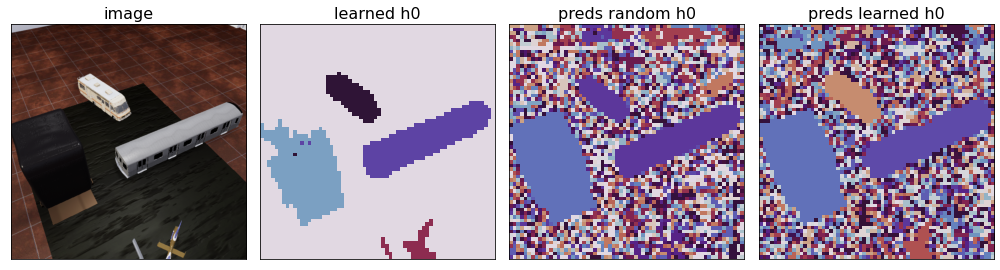

In [70]:
fig, axes = plt.subplots(1,4,figsize=(14,4))
axes[0].imshow(data['image'].permute(1,2,0).cpu().numpy())
# axes[1].imshow(final_hs[-1].argmax(-1).detach().cpu()[0,0], cmap='YlGnBu')
axes[1].imshow(preds.argmax(-1).detach().cpu()[0], cmap='twilight', vmax=preds.shape[-1]+int(rand_background))
axes[2].imshow(comp_masks[0].argmax(-1).detach().cpu().numpy()[0], cmap='twilight')
axes[3].imshow(comp_masks[1].argmax(-1).detach().cpu().numpy()[0], cmap='twilight')

# axes[3].imshow(torch.cat([1-things_mask[:,0,...,None], masks], -1).argmax(-1).detach().cpu().numpy()[0], 
#                cmap='twilight', vmax=masks.shape[-1] + 1)

titles = ['image', 'learned h0', 'preds random h0', 'preds learned h0']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)
plt.tight_layout()
plt.show()

In [71]:
get_iou(pred, gt)

(array([0.74426471]),
 [array([0.78689706, 0.82793051, 0.47925609, 0.88297516])])

In [72]:
get_iou(comp_masks[0].argmax(-1), gt)

(array([0.39302985]),
 [array([0.91624594, 0.00499386, 0.12992224, 0.52095735])])

In [73]:
get_iou(comp_masks[1].argmax(-1), gt)

(array([0.66744053]),
 [array([0.80323154, 0.76128787, 0.27937248, 0.82587022])])

In [74]:
get_iou(torch.cat([1-things_mask[:,0,...,None], comp_masks[0]], -1).argmax(-1), gt)

(array([0.47430503]),
 [array([0.7914387 , 0.01000323, 0.4374468 , 0.65833139])])

In [75]:
get_iou(torch.cat([1-things_mask[:,0,...,None], comp_masks[1]], -1).argmax(-1), gt)

(array([0.7492867]), [array([0.79324502, 0.83372396, 0.49658653, 0.8735913 ])])

In [178]:
# val_result, val_per_example, val_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

In [66]:
val_result, val_per_example[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.6559045403050233,
 array([[0.56390242],
        [0.70521843],
        [0.71922982],
        [0.69148245],
        [0.674486  ],
        [0.61928309],
        [0.53161622],
        [0.71787196],
        [0.60640213],
        [0.69849178]]))

In [76]:
# trainval_result, trainval_per_example, trainval_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 490/490 [03:41<00:00,  2.21it/s]


In [77]:
trainval_result

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6143716833231574

In [91]:
## crossvalidate thingness thresh
threshs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
t_results = dict()
for t in threshs:
    t_trainval_result, trainval_per_example, trainval_best_ious = get_ious(
        val_dataset, None, kpnet, act_net, comp, thresh=t
    )
    t_results[t] = t_trainval_result
    print("thresh: %.3f" % t, t_trainval_result)
for t in threshs:
    print(t, t_results[t])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.010 0.5619349818167043


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.050 0.6162255179201357


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.100 0.6136601587130216


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.150 0.5556069436033607


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.200 0.42587540607213326


100%|██████████| 490/490 [03:42<00:00,  2.20it/s]

thresh: 0.250 0.30343433720913765
0.01 0.5619349818167043
0.05 0.6162255179201357
0.1 0.6136601587130216
0.15 0.5556069436033607
0.2 0.42587540607213326
0.25 0.30343433720913765


In [31]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    if thingness:
        _seg = lambda x, t: (torch.sigmoid(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, thingness=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, thingness=thingness)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4, thingness=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


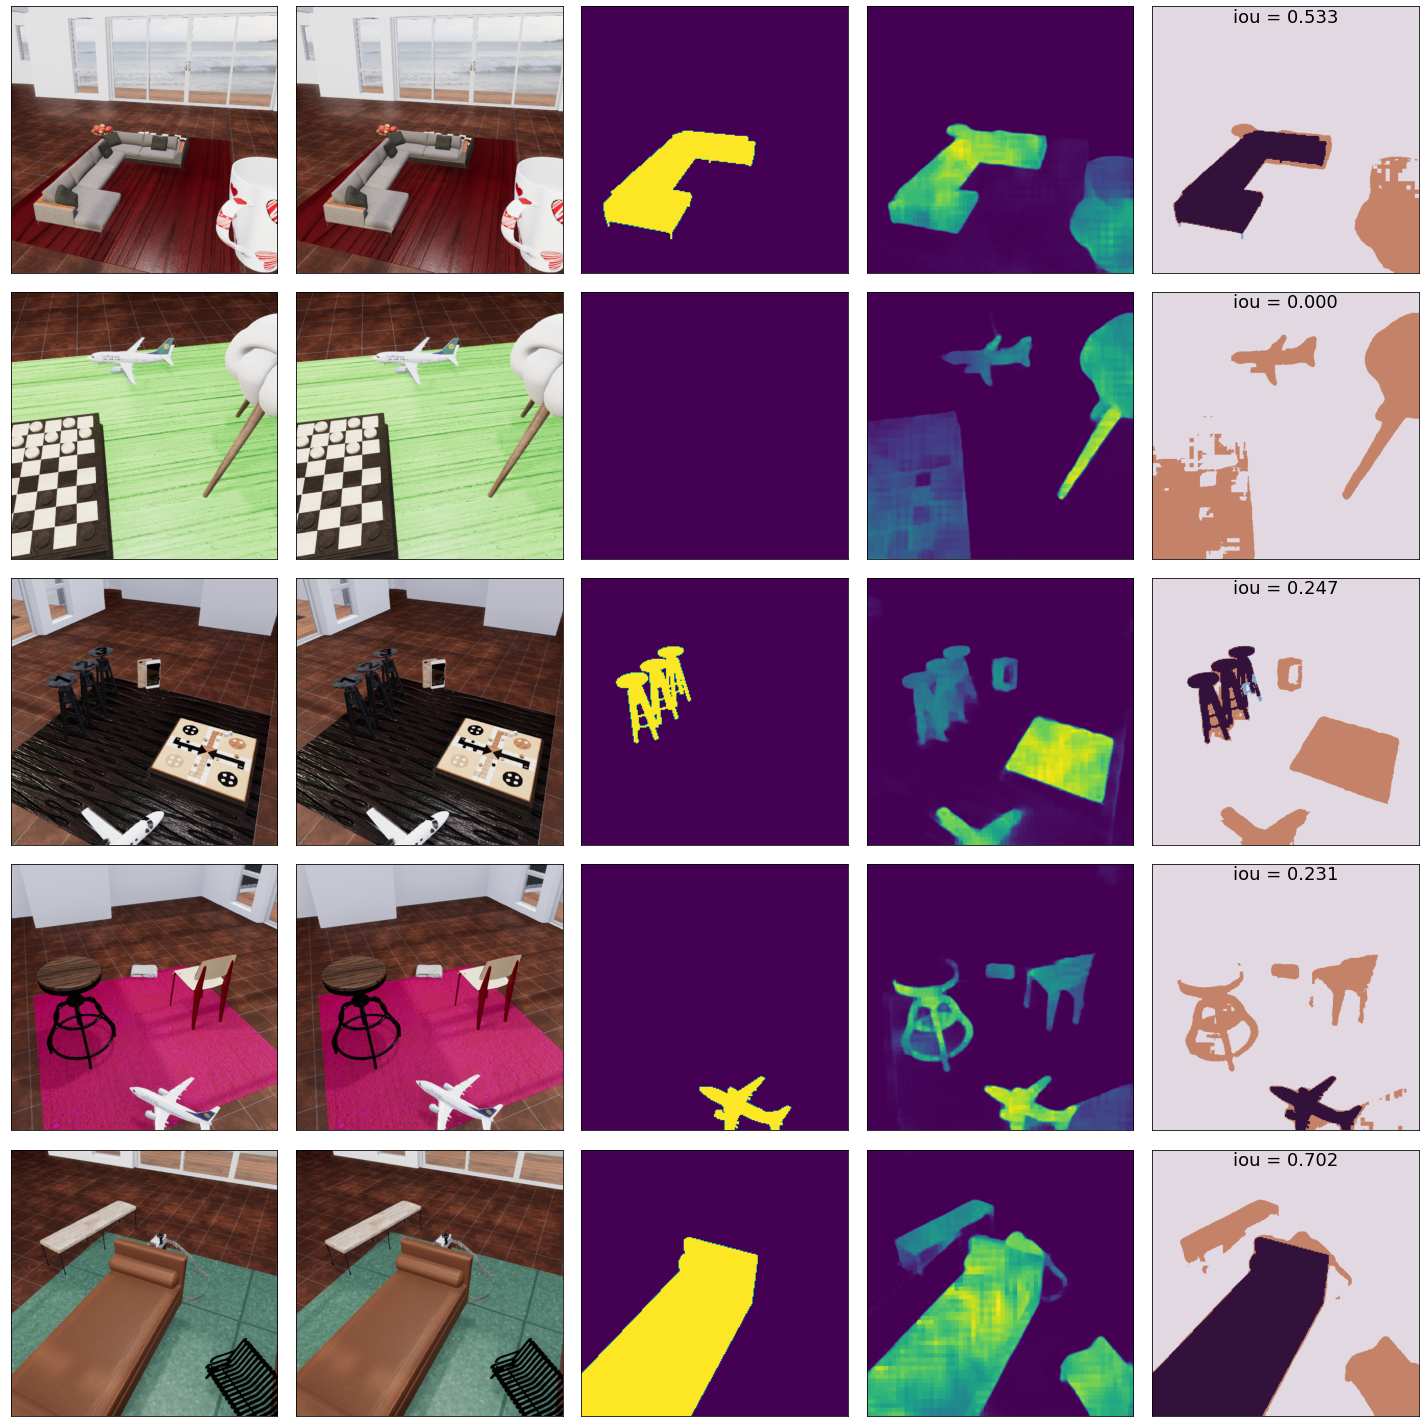

In [32]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
visualize_error_maps(act_net, tdw_dataset, examples=range(5), thresh=0.1, thingness=True)

In [39]:
tdw_dataset.files[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/model_split_0/0009.hdf5'

In [40]:
val_dataset.file_list[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_0/0009'

In [325]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<01:55,  3.84it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.7764962111216519,
  'precision': 0.8384561253722288,
  'recall': 0.9122151587805122},
 {'iou_isnan': 0.042, 'precision_isnan': 0.068, 'recall_isnan': 0.048})

In [326]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:14<02:07,  3.48it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:11<00:00,  3.82it/s]


({'iou': 0.6240724749082448,
  'precision': 0.8703083461953551,
  'recall': 0.7079785642796534},
 {'iou_isnan': 0.028, 'precision_isnan': 0.182, 'recall_isnan': 0.034})

In [153]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.50it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


({'iou': 0.8258794803290415,
  'precision': 0.9140077864749222,
  'recall': 0.8990444173111047},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [154]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:16,  3.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5279725941740948,
  'precision': 0.9000479561979515,
  'recall': 0.5769562252348509},
 {'iou_isnan': 0.03, 'precision_isnan': 0.308, 'recall_isnan': 0.032})

In [161]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:10,  3.38it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.7969608048584764,
  'precision': 0.9451550029757846,
  'recall': 0.8369056144481988},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [162]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


({'iou': 0.5751281585458882,
  'precision': 0.9517182482523737,
  'recall': 0.5998352226939102},
 {'iou_isnan': 0.026, 'precision_isnan': 0.214, 'recall_isnan': 0.028})

In [69]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:55,  3.83it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


({'iou': 0.8434272244586196,
  'precision': 0.9281359996793522,
  'recall': 0.9046012481700816},
 {'iou_isnan': 0.048, 'precision_isnan': 0.086, 'recall_isnan': 0.048})

In [70]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:49,  4.04it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.5981904560853916,
  'precision': 0.9346249676908188,
  'recall': 0.6332787538043337},
 {'iou_isnan': 0.03, 'precision_isnan': 0.26, 'recall_isnan': 0.03})

In [71]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:14<01:54,  3.86it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.8315872222955202,
  'precision': 0.9656698780014051,
  'recall': 0.8579017929928859},
 {'iou_isnan': 0.048, 'precision_isnan': 0.092, 'recall_isnan': 0.048})

In [16]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:10,  3.40it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.8303785279437017,
  'precision': 0.9182744638935051,
  'recall': 0.8974846304309999},
 {'iou_isnan': 0.048, 'precision_isnan': 0.084, 'recall_isnan': 0.048})

In [17]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:09,  3.42it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.581308515985887,
  'precision': 0.9267800688274951,
  'recall': 0.623141531366377},
 {'iou_isnan': 0.032, 'precision_isnan': 0.274, 'recall_isnan': 0.032})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


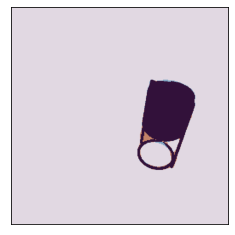

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


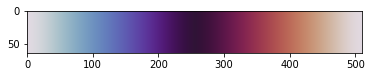

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
torch.randint?

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
x = torch.rand([4, 8, 64]).transpose(1,2)
inds = torch.randint(low=0, high=64, size=[4,6], dtype=torch.long)
b_inds = torch.arange(4, dtype=torch.long)[:,None].repeat(1,6)
inds = torch.stack([b_inds, inds])
x[list(inds)].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([4, 6, 8])

In [227]:
import kmeans
Knet = kmeans.KMeans(num_clusters=32, num_iters=50, append_coordinates=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [228]:
img1, img2, flow, _ = tdw_dataset[3]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
img = img1[None].to(torch.uint8).cuda()
labels = Knet(img)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


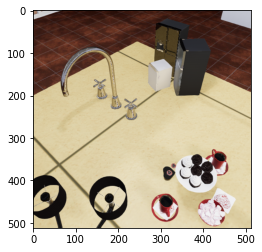

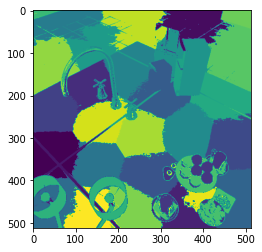

In [230]:
viz(img)
plt.show()
viz(labels)
plt.show()

In [18]:
import compute_training_frames as filtering
knet = torch.nn.DataParallel(filtering.KMeans(16, 50, True)).cuda()
seg_net = filtering.VideoSegmentationModel(model=knet, num_input_frames=1).cuda()
motion_net = net
explain_net = filtering.ExplainedAwayMotion(motion_net, seg_net)

def viz_segments(net, dataset, ex=0, iters=12, test_mode=True):
    img1, img2 = dataset[ex][:2]
    score = net(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    
    axes[0].imshow((img1 / 255.).permute(1,2,0).numpy())
    axes[1].imshow(net.motion_segments[0].detach().cpu().numpy(), cmap='magma')
    axes[2].imshow(net.static_segments[0].detach().cpu().numpy(), cmap='plasma')
    axes[3].imshow(net.out_segments[0].detach().cpu().numpy(), cmap='YlGnBu')
    
    titles = ['Image1', 'MotionSeg', 'StaticSegs', 'FinalSegs']
    for i,ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=20)
        
    plt.tight_layout()
    plt.show()
    
    return score


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


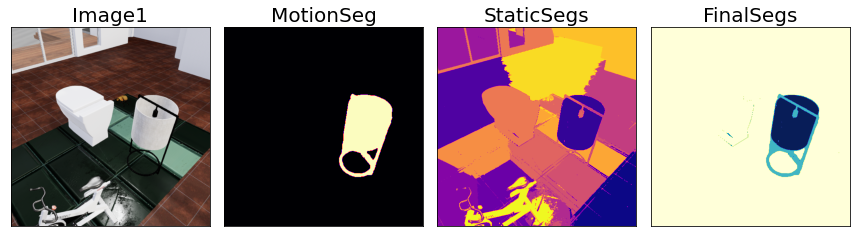

0.020595550537109375

In [19]:
viz_segments(explain_net, tdw_dataset, ex=41)

# read in robonet

In [20]:
import dorsalventral.data.robonet as robonet
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
robonet.get_robot_names()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['berkeley_sawyer',
 'berkeley_widowx',
 'google',
 'meta_data.pkl',
 'penn_baxter_left',
 'penn_baxter_right',
 'penn_kuka',
 'stanford_fetch',
 'stanford_franka',
 'stanford_franka_corr_noise']

In [339]:
robonet_dataset = robonet.RobonetDataset(sequence_length=2)

Using 700 files from robots with names ['berkeley_sawyer', 'berkeley_widowx', 'google', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [342]:
rmov = robonet_dataset[0]

filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj11308.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


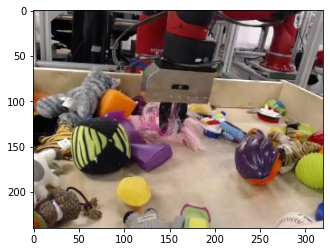

In [352]:
vis_utils.imshow(rmov['images'], None, 1)

In [50]:
robonet_dataset = raft_datasets.RobonetFlowDataset(sequence_length=2, 
                                                   dataset_names=["berk*"],
                                                   train=False
                                                  )
print(robonet_dataset.all_robots)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using 200 files from robots with names ['berk*']
['berkeley_sawyer', 'berkeley_widowx', 'google', 'meta_data.pkl', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj19970.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


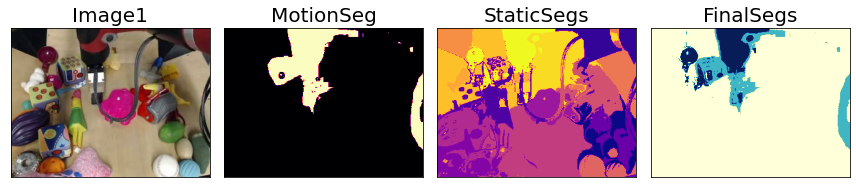

0.07240885496139526

In [23]:
viz_segments(explain_net, robonet_dataset, 15)

In [ ]:
net = nn.DataParallel()

In [51]:
load_path = '../models/raft-sintel.pth'
# load_path = '../checkpoints/raft-tdw-bn-fullplay.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


../models/raft-sintel.pth
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)


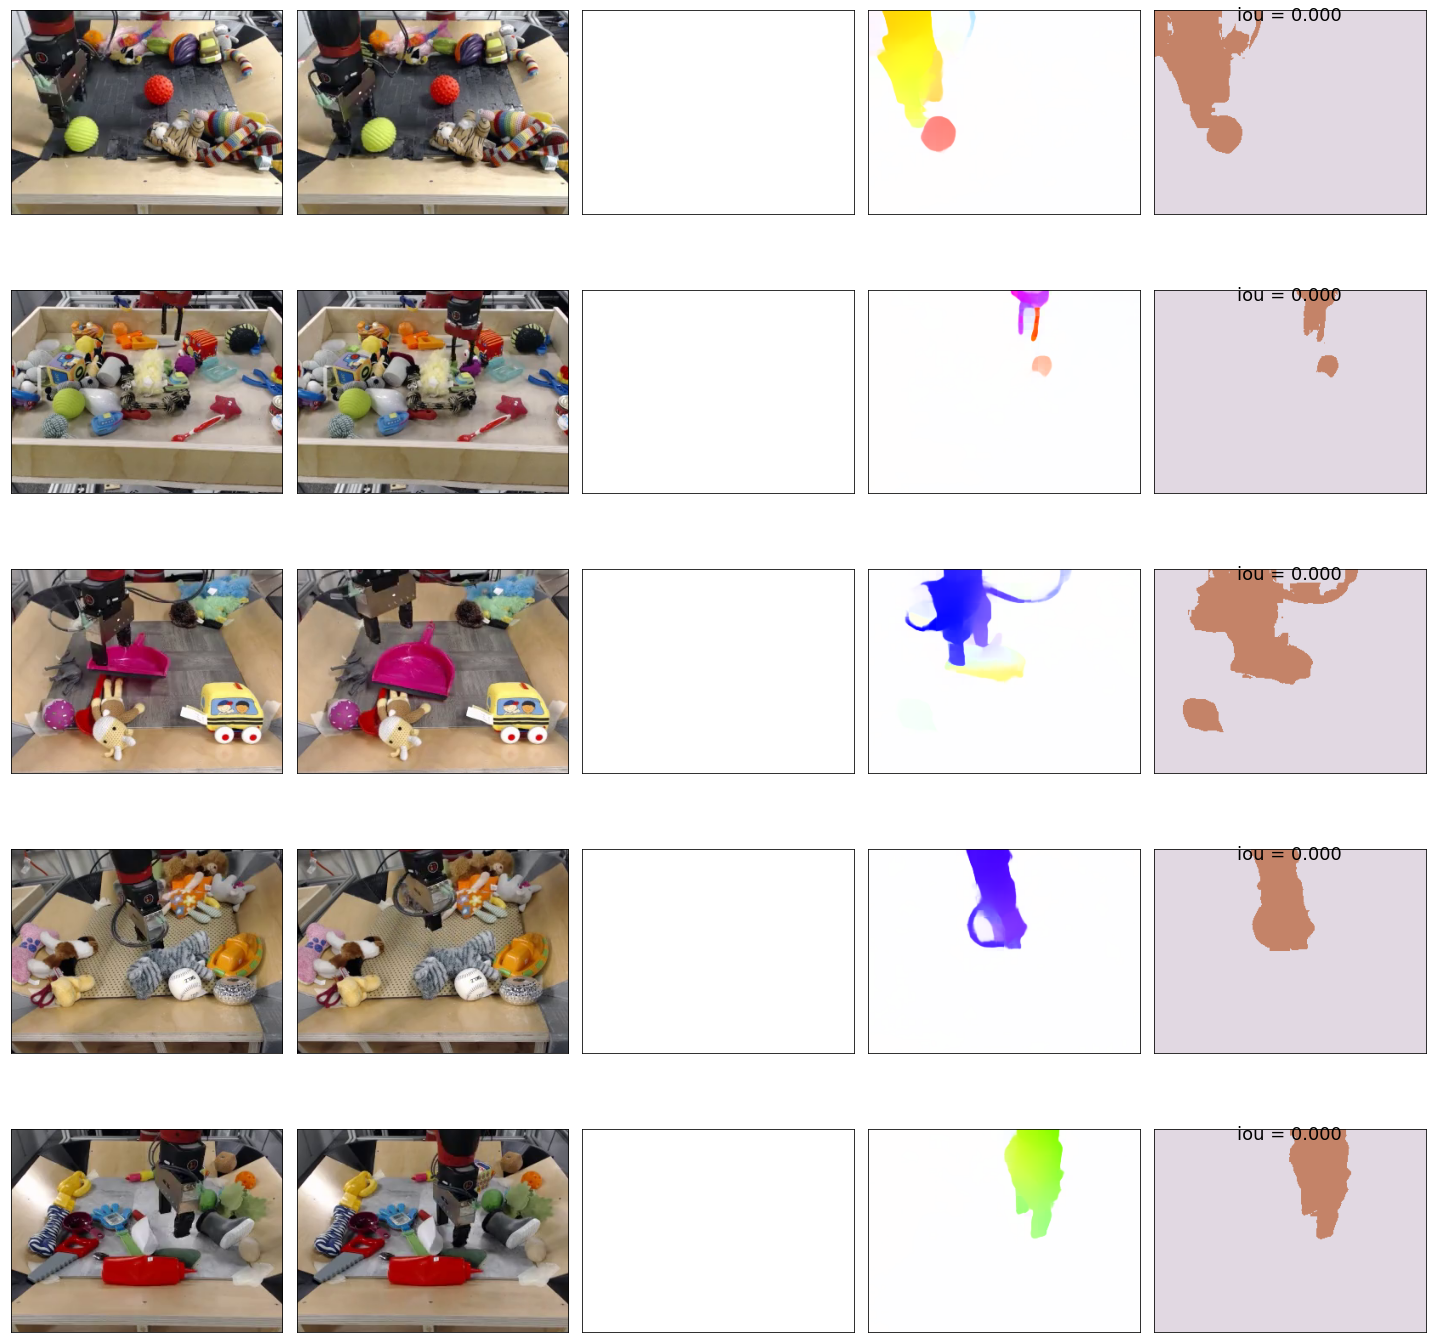

In [52]:
print(load_path)
visualize_error_maps(net, robonet_dataset, examples=range(5,10), thresh=0.5)